# The Turbulence Database

Login to https://apps.sciserver.org/compute/

Download this code at https://git.io/Jecfu

Notebooks consist of Markdown cells (with a white background, like this one) and Code cells (with a gray background)

Markdown cells contain explanatory text, it accepts $\LaTeX$ syntax as well

Code cells contain executable code. To run the code, click inside a Code cell and click the Play button above (or use the keyboard shortcut Shift-Enter)

Other available databases: http://sciserver.org/integration/

Help with database functions
http://turbulence.pha.jhu.edu/help/c-fortran/

libJHTDB has all the functions we need
https://github.com/idies/pyJHTDB/blob/master/pyJHTDB/libJHTDB.py

Some help from this repository
https://github.com/aguemes/JHTDB/blob/master/main.py

All available functions
http://turbulence.pha.jhu.edu/analysisdoc.aspx

Other colormaps:
https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

In [4]:
import numpy as np
from pyJHTDB import libJHTDB
import ctypes
# plotting and data analysis
import matplotlib.pyplot as plt
import scipy.stats as st
# colormap
from matplotlib import cm
cmap=cm.get_cmap('viridis')

In [5]:
# this function gets velocity in the direction x for all points in the list pos
# at all times in the list time
def loadData(pos, time):
    # load shared library
    lTDB = libJHTDB()
    #initialize webservices
    lTDB.initialize()
    
    #lTDB.lib.turblibSetExitOnError(ctypes.c_int(1));
    lTDB.add_token(auth_token)
    
    # for each instant, get data at every specified x
    for t in np.arange(time.size):
        temp = lTDB.getData(time[t], pos, data_set=data_set, sinterp=sinterp, tinterp=tinterp, getFunction = 'getVelocity', make_modulo=False)
        if t == 0:
            # 0 is the velocity coordinate we are getting
            u = temp[:, :, 0]
        else:
            u = np.dstack((u, temp[:, :, 0]))

    lTDB.finalize()
    return u

In [6]:
# public token: download at most 64^2 points at a time with this token
with open('token_gba', 'r') as file:
    auth_token = file.read()

In [7]:
data_set="isotropic1024coarse"
output_filename="isotropic"

In [8]:
sinterp = "Lag6" #spatial interpolation
tinterp = "NoTInt"
# Coarse: 5028 timesteps, time t between 0 and 10.056
# Range is [0,2 \pi]^3, 1024^3 nodes
dt = 10.056/5028

# simulation properties
L = 2*np.pi
N = 256

time = np.array([1000])*dt
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
pos = np.zeros((x.shape[0], y.shape[0], 3), np.float32)
pos[:, :, 0] = x[np.newaxis, :]
pos[:, :, 1] = y[:, np.newaxis]
pos[:, :, 2] = 3.14

`pos` is a list of all points requested to the database

$$
\mathrm{pos} = 
\begin{pmatrix}
x_1 & y_1 & z_1 \\
x_2 & y_2 & z_2 \\
& \vdots & \\
x_n & y_n & z_n \\
\end{pmatrix}
$$

In [9]:
u = loadData(pos, time)
np.savez(output_filename, u, pos, time)

In [10]:
with np.load(output_filename+".npz") as data:
    u = data['arr_0']
    pos = data['arr_1']
    time = data['arr_2']

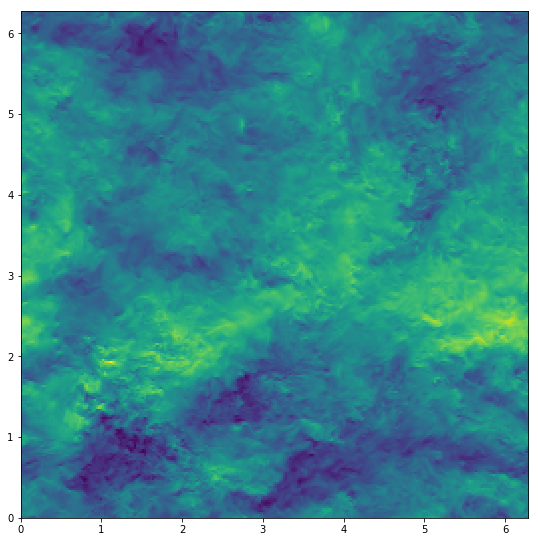

In [11]:
fig = plt.figure(figsize = (20, 20))
a = fig.add_subplot(121)
a.imshow(u[:, :], extent = [x[0], x[-1] - x[0], y[0], y[-1] - y[0]], interpolation = 'none', aspect = 'equal')
plt.show()


# PDF $\delta_r u$

In [12]:
# pdf of velocity difference is calculated at these distances
# measured in units of grid spacing
dists = 2**np.arange(1,int(np.log2(N)))

In [13]:
data = np.array([ (u - np.roll(u,dist)).flatten() for dist in dists ])

In [14]:
# PDF range
urange = np.linspace(data.min(),data.max(),200)

In [15]:
hist = [ np.histogram(data[j], bins=100) for j in range(len(dists)) ]
pdf =  [ st.rv_histogram(hist[j]) for j in range(len(dists)) ]

/home/idies/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


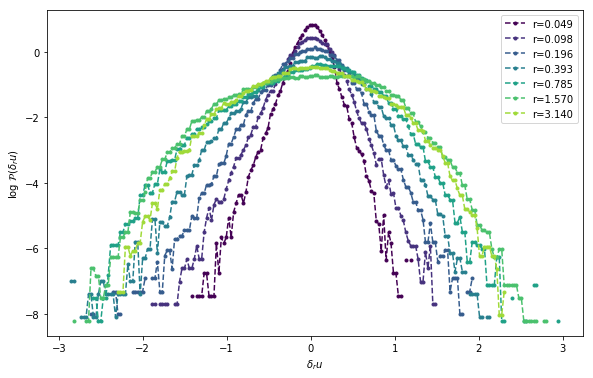

In [16]:
### Plot figure

plt.figure(figsize=(9.6,6))
plt.ylabel(r'$\log \ \mathcal{P}(\delta_r u)$')
plt.xlabel(r'$\delta_r u$')

for j in range(len(dists)):
    plt.plot(urange, np.log( pdf[j].pdf(urange) ), '.--',
             color=cmap(j/len(dists)),
             label="r={:.3f}".format(dists[j]*6.28/256))
 
plt.legend()
plt.show()

# 2-point velocity correlation function

$$
f(\rho) = \frac{\langle u(\mathbf{x}) u(\mathbf{x}+r \mathbf{\hat{x}}) \rangle}{u_0^2}
$$

Cross-correlation theorem

$$
f * g=\mathfrak{F}^{-1}[\overline{F} G]
$$

In [23]:
sinterp = "Lag6" #spatial interpolation
tinterp = "NoTInt"

# simulation properties
# Coarse: 5028 timesteps, time t between 0 and 10.056
# Range is [0,2 \pi]^3, 1024^3 nodes
dt = 10.056/5028
L = 2*np.pi
dx= L/1024

# number of points to be sampled on a line
N = 1024

time = np.array([1000])*dt
x = np.linspace(0, L-dx, N)
y = np.pi
z = np.pi
pos = np.array([ [a,y,z] for a in x ],np.float32)

# correlation function will be calculated at the following distances
dists = np.arange(0,N,1)

In [24]:
def loadLineData(pos, time, axis):
    lTDB = libJHTDB()
    #initialize webservices
    lTDB.initialize()

    #lTDB.lib.turblibSetExitOnError(ctypes.c_int(1));
    lTDB.add_token(auth_token)

    # for each instant, get data at every specified x
    for t in np.arange(time.size):
        temp = lTDB.getData(time[t], pos, data_set=data_set, sinterp=sinterp, tinterp=tinterp, getFunction = 'getVelocity', make_modulo=False)
        if t == 0:
            # 0 is the velocity coordinate we are getting
            u = temp[:, axis]
        else:
            u = np.dstack((u, temp[:, axis]))

    lTDB.finalize()

    return u

In [47]:
# load data for u and store it
ux = loadLineData(pos, time, 1)
np.savez("ux_line", ux, pos, time)

In [48]:
# longitudinal 2-pt correlation function in real space
# this is called f in the lecture notes
# * is element-wise matrix multiplication
f = np.array([ (ux * np.roll(ux,dist)) for dist in dists ]) / np.mean(ux*ux)
f = np.mean(f,axis=1)

In [52]:
# 2-pt correlation function calculated with Fourier transform
uk2 = np.abs( np.fft.fft(ux) )**2
cf = np.fft.ifft( uk2 ) /L
# ff stands for "f fourier"
ff = np.real(cf)/np.real(cf[0])

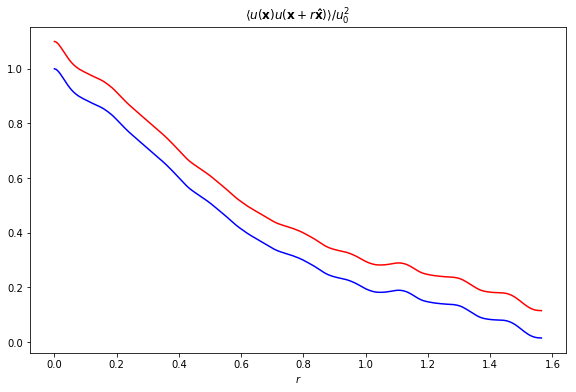

In [56]:
### Plot figure

plt.figure(figsize=(9.6,6))
plt.title(r'$\langle u(\mathbf{x}) u(\mathbf{x}+r \mathbf{\hat{x}}) \rangle / u_0^2$')
plt.xlabel(r'$r$')

plt.plot( dists[:N//4]*L/N, f[:N//4] , color='blue')

plt.plot( np.arange(N//4)*L/N, .1+ff[:N//4] , color='red')

#plt.legend()
plt.show()

# Lagrangian Trajectories

In [68]:
dt = 10.056/5028
time = np.arange(0,5028)*dt

In [337]:
lTDB = libJHTDB()
lTDB.initialize()
lTDB.lib.turblibSetExitOnError(ctypes.c_int(0));
lTDB.add_token(auth_token)

d0 = [L/4,3*L/4]

times = np.arange(0,5028)*dt
x0 = np.array([ (a,b,c) for a in d0 for b in d0 for c in d0 ],np.float32)
trajs = np.array([x0])

for t in times:
    u = lTDB.getData(t, x0, data_set=data_set, sinterp="Lag4", tinterp="NoTInt", getFunction = 'getVelocity', make_modulo=False)
    x0 += u * dt # Euler evolution
    trajs = np.concatenate(( trajs, [x0] ))
    
lTDB.finalize()

/home/idies/miniconda3/lib/python3.7/site-packages/pyJHTDB-20190210.4-py3.7-linux-x86_64.egg/pyJHTDB


In [344]:
np.savez("lag-traj-001", trajs, times)

In [65]:
with np.load("lag-traj-001.npz") as data:
    trajs = data['arr_0']

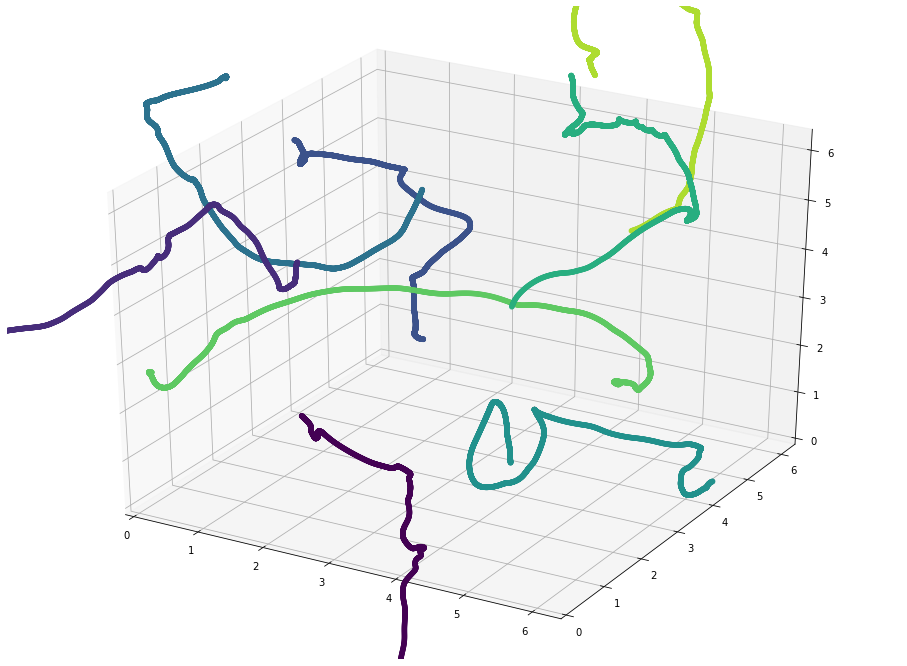

In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([0,L])
ax.set_ylim([0,L])
ax.set_zlim([0,L])

for p in np.arange(0,8): # p is for particle
    ax.scatter(trajs[:,p,0],trajs[:,p,1],trajs[:,p,2], marker='o', color=cmap(p/8))

plt.show()

# Richardson Dispersion

In [76]:
def getTrajs(x0,times):
    
    # initialize trajectories with initial positions
    trajs = np.array([x0])
    
    for t in times:
        if x0.all() < L:
            u = lTDB.getData(t, x0, data_set=data_set, sinterp="Lag4", tinterp="NoTInt", getFunction = 'getVelocity', make_modulo=False)
            x0 += u * dt # Euler evolution
            trajs = np.concatenate(( trajs, [x0] ))
        else:
            break

    return trajs

In [103]:
lTDB = libJHTDB()
lTDB.initialize()
lTDB.lib.turblibSetExitOnError(ctypes.c_int(0));
lTDB.add_token(auth_token)

/home/idies/miniconda3/lib/python3.7/site-packages/pyJHTDB-20190210.4-py3.7-linux-x86_64.egg/pyJHTDB


In [23]:
times = np.arange(0,5028)*dt
# 2 neighbor points, I want to observe separation of trajectories that start close
x0 = np.array([ [L/2,L/2,L/2], [L/2,L/2,L/2+dx] ],np.float32)

NameError: name 'dx' is not defined

In [104]:
i = 2
trajs = getTrajs(x0,times)
np.save("lag_dispersion_{:03d}".format(i), trajs)

In [136]:
# get trajectories for points from L/8 to 7/8*L
d0 = 1024//8
n0 = 6*1024//8
r  = range(1,n0,240)

In [139]:
x0 = np.array([ [d0+a,d0+b,d0+c] for a in r for b in r for c in r ])*dx

In [ ]:
for y in x0:
    
    print(y)
    
    y0 = np.array( [y,y+[dx,0,0]], np.float32 )
    trajs = getTrajs(y0,times)
    np.save("lag_dispersion_{:05.3f}_{:05.3f}_{:05.3f}_{:1d}".format(y[0],y[1],y[2],0), trajs)
    
    y0 = np.array( [y,y+[0,dx,0]], np.float32 )
    trajs = getTrajs(y0,times)
    np.save("lag_dispersion_{:05.3f}_{:05.3f}_{:05.3f}_{:1d}".format(y[0],y[1],y[2],1), trajs)
    
    y0 = np.array( [y,y+[0,0,dx]], np.float32 )
    trajs = getTrajs(y0,times)
    np.save("lag_dispersion_{:05.3f}_{:05.3f}_{:05.3f}_{:1d}".format(y[0],y[1],y[2],2), trajs)
    
    y0 = np.array( [y,y-[dx,0,0]], np.float32 )
    trajs = getTrajs(y0,times)
    np.save("lag_dispersion_{:05.3f}_{:05.3f}_{:05.3f}_{:1d}".format(y[0],y[1],y[2],3), trajs)
    
    y0 = np.array( [y,y-[0,dx,0]], np.float32 )
    trajs = getTrajs(y0,times)
    np.save("lag_dispersion_{:05.3f}_{:05.3f}_{:05.3f}_{:1d}".format(y[0],y[1],y[2],4), trajs)
    
    y0 = np.array( [y,y-[0,0,dx]], np.float32 )
    trajs = getTrajs(y0,times)
    np.save("lag_dispersion_{:05.3f}_{:05.3f}_{:05.3f}_{:1d}".format(y[0],y[1],y[2],5), trajs)

[0.79153409 0.79153409 0.79153409]
[0.79153409 0.79153409 2.26415564]
[0.79153409 0.79153409 3.7367772 ]
[0.79153409 0.79153409 5.20939876]


In [84]:
lTDB.finalize()

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from glob import glob

In [5]:
files = glob('./lag_dispersion_*')

In [8]:
trajs = np.array([ np.load(f) for f in files ])

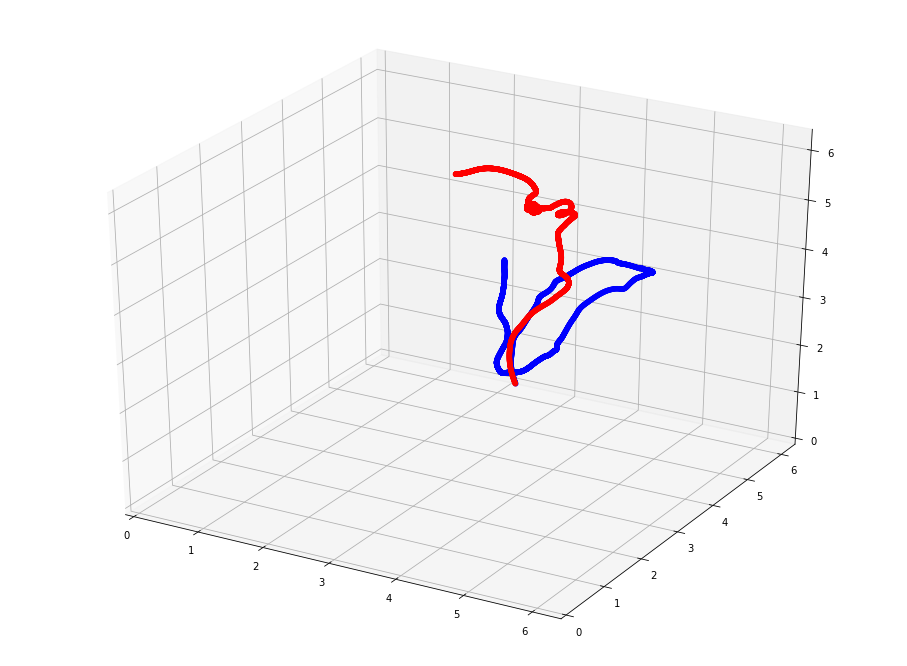

In [15]:
# number of trajectory
tn = 300

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([0,L])
ax.set_ylim([0,L])
ax.set_zlim([0,L])

ax.scatter(trajs[tn,:,0,0],trajs[tn,:,0,1],trajs[tn,:,0,2], marker='o', color='red')
ax.scatter(trajs[tn,:,1,0],trajs[tn,:,1,1],trajs[tn,:,1,2], marker='o', color='blue')

plt.show()

In [27]:
dims = trajs.shape
dr2 = np.empty([dims[0],dims[1]])

In [28]:
for i in range(dims[0]):
    dr2[i,:] = np.apply_along_axis( lambda x: x[0]**2+x[1]**2+x[2]**2 , 1, trajs[i,:,0,:] - trajs[i,:,1,:] )

In [30]:
mdr2 = np.mean(dr2, axis=0)
del dr2

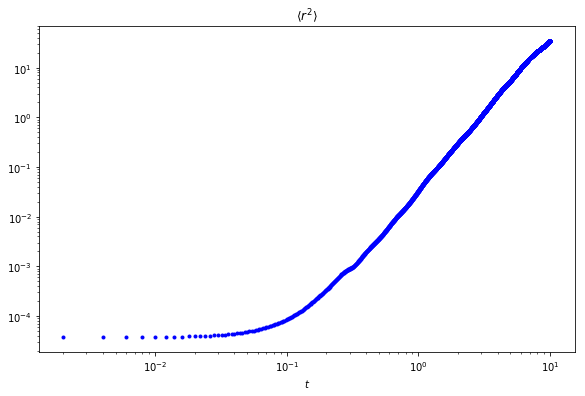

In [59]:
### Plot figure

plt.figure(figsize=(9.6,6))
plt.title(r'$\langle r^2 \rangle$')
plt.xlabel(r'$t$')

plt.yscale('log')
plt.xscale('log')

plt.plot( times, mdr2 , '.', color='blue')

plt.show()

In [33]:
from scipy.optimize import curve_fit

In [70]:
def Rlaw(t,a,b):
    # Richardson scaling
    return a * np.power(t,b)

def Tlaw(t,a):
    # Richardson scaling
    return a * np.power(t,3)

In [57]:
pfit, perr = curve_fit(Rlaw, times[500:4000], mdr2[500:4000] )

In [71]:
tfit, terr = curve_fit(Tlaw, times[500:4000], mdr2[500:4000] )

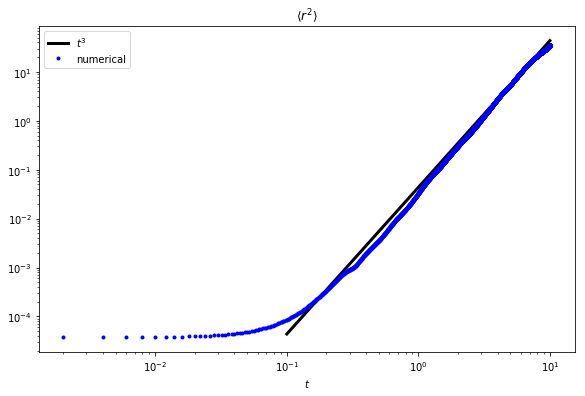

In [80]:
### Plot figure

plt.figure(figsize=(9.6,6))
plt.title(r'$\langle r^2 \rangle$')
plt.xlabel(r'$t$')

plt.yscale('log')
plt.xscale('log')

plt.plot( times[50:5000], Tlaw(times[50:5000], *tfit), 'k-', label=r'$t^3$'.format(pfit[1]), linewidth=3.)
plt.plot( times, mdr2 , '.', color='blue', label='numerical')
#plt.plot( times[200:5000], Rlaw(times[200:5000], *pfit), 'r-', label=r'fit: {:.2f}'.format(pfit[1]), linewidth=3.)

plt.legend()
plt.show()